# Making Space Invaders Fun and Accessible with Brain-Computer Interfacing

## Executive Summary

By optimising event detection and classification, our model had an accuracy of 88% on the test data set. The Max-Min-Range classifier had the best tradeoff between minimizing latency and maximising accuracy, and hence we chose it for our model.
After performing a plethora of experiments, we developed an optimal strategy for data collection. This includes keeping the electrodes at least 3cm apart, and having the data collector perform fast eye movements.
Re-designing Space Invaders to be controlled using left and right eye movements is not solely useful as an entertaining game with potential commercial success. It is a tool that can act as a learning interface to teach individuals how gesture control performs (as the technology is inevitably integrated into our everyday lives) by using a familiar, nostalgic game such as space invaders. Additional applications include inclusive gaming for those with muscular impairments and building a foundation model for future projects to extend.

### Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import time
from scipy.fft import fft, fftfreq, fftshift
from scipy import signal
from copy import deepcopy
from catch22 import catch22_all
import catch22
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from numba import njit
from weighted_levenshtein import lev
import struct
import warnings
import serial
warnings.filterwarnings('ignore')

# Update this to point to the report folder
PATH = "../"
# To run all computation, change to True. Otherwise, precomputed files will be loaded instead.
compute_all = False
# If running, ensure the following line is commented out. It disables plots for knitting to html purposes. 
# %matplotlib agg

# Set seed for reproducibility
np.random.seed(420) 
# Path to outputs folder
OUT_PATH = PATH + "report_outputs/"
# Path to data
IN_PATH = PATH + "data/"
# Path to other file dependencies
DEP_PATH = PATH + "requirements/other_files/"




## Motivation & Background

Over the past two decades, profound advancements in technology such as facial recognition, gesture control, virtual assistants and other instances of machine learning have gradually been integrated into everyday life. With virtual reality worth over \$21 billion alone {cite}`VR`, the gaming industry is evidently undergoing a similar transformation. The financial success of other games such as Pokemon Go, which used augmented reality to re-develop the themes and goals of its franchise, is reason enough to design and implement a game that is similarly controlled by one of these technological advancements. 

This project involves using gesture control, one of these technological advancements, to re-develop Space Invaders, the iconic 80’s game which grossed an equivalent of $13 billion {cite}`SpaceInvaders`, using left and right eye movements as the spaceship's controls. These movements are represented by signals generated by the Backyard Brains Spikerbox {cite}`BYB`.

Our target market is anyone interested in leading technologies and gaming, akin to Pokemon Go’s and the original Space Invaders audience. A short survey was conducted and out of 33 people, 85% said they would be interested in this version of Space Invaders. This demonstrates potential commercial success with a remastered launch.

The fundamental aim of this project is to accurately and efficiently detect eye movements, and distinguish between left and right signals. This becomes an arduous task if solely Physics or Data Science is used to implement this project. The workflow diagram in {numref}`flow` visually explains the role of each discipline, and how the success of the final product depends on the integration of these sciences. In particular, the Physics discipline is responsible for the experimental design and collection of data, to generate a clean, noticeable signal that is representative of a larger population. The Data Science discipline is responsible for implementing code that reads this data, searches for the occurrence of a movement and classifies the specific gesture. Additionally, the integrated knowledge and skills of the two disciplines led to designing and implementing a method that evaluates the performance of the detection and classification code in terms of accuracy and efficiency. 

Thus, using the skills and knowledge of Physics and Data Science, a well-tested gesture controlled version of Space invaders can be developed.


```{figure} ../report_outputs/flow.png
---
scale: 30%
name: flow
---
Workflow diagram illustrating the process undergone by both Physics and Data Science disciplines in the re-development of the game Space Invaders.
```
<!-- reference by {numref}`flow` -->

## Methods
(methods:exp)=
### Experimentation & Data Collection

In reference to {numref}`flow`, the first step in the re-development of Space Invaders requires experimenting with the Spikerbox to collect data which is representative application of the game. The aim of experimentation is to define characteristic signal signatures (such as left and right eye movements) and determine how these change as physical aspects of the experimental design vary.

#### Physical Experiments Performed & Findings

The Backyard Brains Spikerbox was used to collect data for testing the classifiers. Eye movement data was collected by having someone look at 3 objects; one placed directly in front, one to the left and one to the right, so that clean and noticeable signals can be generated. We tested many different ways we can create distinguishable signals and discovered optimal electrode placements to create the most easily detectable signals for each movement. This included electrode placements in both a vertical configuration, for up down eye movements and a horizontal configuration, for left right eye movements. 
Through experimentation, we found muscle movements, such as raising eyebrows and smiling, generated a different signal to eye movements and experimented with blinks. The speed between the signals was varied to see how fast the signals can be for the classifiers to function accurately on. The speed of the eye movements was also tested to see how effectively the classifier classifies signals that are slightly more stretched out. 
We then collected a combination of all the different signals at varying speeds to simulate how the signals will look like when someone is playing the game and tested it on the classifiers. 


#### Immediate Implications of Findings 

From our above findings, we can immediately adapt the final experimental design to ensure the cleanest and most noticeable signal is generated. 
- Throughout the rest of the experiment, data was collected by placing the electrodes at least 3cm apart in a horizontal configuration above the eyebrow. 
- The user was instructed to move their eyes quickly. However, these movements are separated by minimum time intervals to prevent merging the signals. 
- Throughout data collection, markers were placed on the left and right of the user to act as a target, ensuring they moved their eyes far enough to generate a strong signal. 
- Data was collected from more than one individual to ensure the dataset is representative of a larger group. 
- To overcome the issue due to noise, it would be appropriate during pre-processing to use a noise filter. 
- To overcome the issue due to changing signal amplitude, pre-processing of the signal should additionally involve normalisation or calibration.

#### Sample Collection of Data
We have prepared 8 wave files (.wav) to the following specifications:
- 50 seconds in length
- First 5 seconds is a calibration period - no movements performed
- A sequence of left and right movements are performed for the remaining 45 seconds
- Each file is accompanied with a labels textfile (.txt) containing the timestamps and labels of every event in the wavefile. '1' corresponds to a left eye movement, and '2' corresponds to a right eye movement.
- Each .wav file has a range of [0, 1024], but are centred to [-512, 512] within the `load_data` function defined below.

Two of the eight files were randomly selected as the test set, and the rest were assigned to the training set. 

In [2]:
def load_data(path, fnames, scale_factor = 1, shift_factor = -512, fix_alessandro=False, offsets=None):
    waves = {}
    labels = {}
    for file in fnames:
        # Load in wave file
        samprate, wav_array = wavfile.read(path+file+".wav")
        wav_array = wav_array*scale_factor
        wav_array += shift_factor
        # Fix the bug in alessandro's code
        if fix_alessandro:
            fixed_wav = []
            step = 999
            offset = offsets[file]
            for j, i in enumerate(range(offset, len(wav_array)-step, step)):
                if j == 0:
                    fixed_wav.append(np.flip(wav_array[0:i+step]))
                fixed_wav.append(np.flip(wav_array[i:i+step]))
            waves[file] = np.concatenate(fixed_wav)
        else:
            waves[file] = wav_array
        # Load in label file
        labels_dat = pd.read_csv(path+file+".txt", sep=",\t", skiprows=1)
        labels_dat.columns = ["label", "time"]
        labels_dat.label = ["L" if label == 1 else "R" for label in labels_dat.label]
        labels[file] = labels_dat
    print(f"Successfully loaded {len(waves)} wavefiles:")
    print("\n".join(sorted(waves.keys())))
    return waves, labels

fnames = ["data1", "data2", "data3", "data4", "data5", "data6", "data7", "data8"]

# Offsets to fix the error in alessandro's code
offsets = {"data1":0,
           "data2":0,
           "data3":0,
           "data4":0,
           "data5":-5,
           "data6":0,
           "data7":-1,
           "data8":0}

# Randomly select two files for the test set, remainder as training
test_files = np.random.choice(fnames, 2, replace=False)
training_files = list(set(fnames) - set(test_files))

# Training Data
waves, labels = load_data(
    IN_PATH, training_files, scale_factor = 1, shift_factor = -512, fix_alessandro=True, offsets=offsets)

# Test Data
test_waves, test_labels = load_data(
    IN_PATH, test_files, scale_factor = 1, shift_factor = -512, fix_alessandro=True, offsets=offsets)

# Define Calibration Window and Sample Rate: 10,000 Hz
calibration_window_sec = 5
samprate = 10_000


Successfully loaded 6 wavefiles:
data1
data2
data3
data4
data6
data8
Successfully loaded 2 wavefiles:
data5
data7


Next, we convert the singular timestamps in the labels dataframe to the time interval of the entire event. There was a minor data quality issue with some of the timestamps which caused some files to have slightly shifted timestamps. To fix this, we went through and manually defined the interval for each file (the time to add before and after the timestamp to get the desired interval). We did this once to encompass the entire wave signal, and another time to only cover the first hump of the signal.


In [3]:
# First hump
time_buffers_hump = {
    "data1":(-0.3, 0.55),
    "data2":(-0.3, 0.55),
    "data3":(-0.3, 0.55),
    "data4":(-0.5, 0.75),
    "data5":(-0.5, 0.75),
    "data6":(-0.5, 0.75),
    "data7":(-0.5, 0.75),
    "data8":(-0.5, 0.75)
}

# Whole wave
time_buffers_whole = {
    "data1":(-0.2, 1.15),
    "data2":(-0.2, 1.15),
    "data3":(-0.2, 1.15),
    "data4":(-0.4, 1.35),
    "data5":(-0.4, 1.35),
    "data6":(-0.4, 1.35),
    "data7":(-0.4, 1.35),
    "data8":(-0.4, 1.35),
}


#### Streaming Algorithm Design

First, we must design the basic structure of our streaming algorithm. The algorithm will consist of two parts, the first is event detection, and the second is classification. As the streaming data comes in, we will only keep a window of fixed length in memory, effectively behaving as a sliding window at the front of the stream. This window updates in discrete intervals of some *buffer length*, and we will deem this window the *classification window*. 

Within that classification window, we will fix another smaller window that slides along with the classification window. This subset of the classification window is what we will test an event criterion on, and is hence called the *detection window*. 

Each time the window is updated by the stream, the event criterion is tested on the detection window. To minimise false positives, that criterion will need to pass a set number of times, dictated by the `consecutive_event_triggers` parameter.

Once the event criterion has passed `consecutive_event_triggers` times, we pass the classification window to the classifier algorithm and block the classifier from detecting another event. When the event criterion has failed `consecutive_nonevent_reset` times, we prime the streaming algorithm to predict events again. This is to stop the algorithm from detecting the same event twice.



In [4]:
# Function that reads in the kth <inputBufferSize> sized segment of the array
# Simulates streaming condition on recorded wavefiles.
def read_arduinbro(wav_array, inputBufferSize, k):
    if inputBufferSize*(k+1) < len(wav_array):
        data = wav_array[(inputBufferSize*(k)):(inputBufferSize*(k+1))]
    else:
        data = wav_array[(inputBufferSize*(k))::]
    return np.flip(data)


In [5]:
def streaming_classifier(
        wav_array,                             # Either the array from file (or ser if live = True)
        samprate,
        classifier,
        input_buffer_size_sec = 0.1,           # Buffer size in seconds
        store_events = False,                  # Whether to return the classification window array for
                                                   # debugging purposes
        store_times = False,                   # Store time taken for each classification
        live = False,
        FIFO_filename = None,
        create_FIFO_msg = None,

        classifier_params = {},
        classification_window_size_sec = 1.5,  # Total detection window [s]

        calibration_window_size_sec = 5,       # The length of the calibration period to define the threshold
        calibration_statistic_function = None, # Function that calculates the calibration statistic

        detection_window_size_sec = 0.5,
        detection_window_offset_sec = 0.5,
        event_test_statistic_function = None,  # Function that calculates the test statistic
        event_threshold_factor = 0.5,          # The scale factor of the calibration stat that will become
                                                   # the threshold
        flip_threshold = False,                # Threshold is a lower bound if true, upper bound if false
        consecutive_event_triggers = 3,        # How many threshold triggers need to occur in a row for an 
                                                   # event to be called
        consecutive_nonevent_reset = 10         # How many threshold failures need to occur in a row for the
                                                   # classifier to be primed for a new event
        ):

    # Connect to fifo
    if FIFO_filename is not None:
        fifo = os.open(FIFO_filename, os.O_WRONLY)
    
    if store_events:
        predictions_storage = []
    if store_times:
        classification_times = []
    predictions = ""
    predictions_timestamps = []

    # Initialise variables
    N_loops_over_window = classification_window_size_sec//input_buffer_size_sec
    input_buffer_size = int(round(input_buffer_size_sec * samprate))
    detection_window_offset = int(round(detection_window_offset_sec * samprate))
    detection_window_size = int(round(detection_window_size_sec * samprate))
    
    # Initialise Calibration
    calibrate = True
    N_loops_calibration = calibration_window_size_sec//input_buffer_size_sec

    # Initialise Event History
    num_event_history = max(consecutive_event_triggers,
                            consecutive_nonevent_reset) + 1 
    event_history = np.array([False]*num_event_history)

    # Determine length of stream
    if live:
        N_loops = np.inf
    else:
        total_time = len(wav_array)/samprate
        N_loops = (total_time*samprate)//input_buffer_size

    # Prime the classifier for new event
    primed = True
    
    ### Start stream ###
    k = 0
    while k < N_loops:
        if live:
            data = read_arduino(wav_array,input_buffer_size)
            data_temp = process_data(data)
        else:
            data_temp = read_arduinbro(wav_array, input_buffer_size, k)
        if k < N_loops_over_window:
            if k == 0:
                data_cal = data_temp
                data_window = data_temp
            else:
                data_window = np.append(data_temp, data_window)
                if calibrate:
                    data_cal = np.append(data_temp, data_cal)
            k+=1
            continue
        else:
            data_window = np.roll(data_window,len(data_temp))
            data_window[0:len(data_temp)] = data_temp
            if calibrate:
                data_cal = np.append(data_temp,data_cal)
                if (k > N_loops_calibration):
                    cal_stat = calibration_statistic_function(data_cal)
                    event_threshold = cal_stat*event_threshold_factor
                    calibrate = False
                k+=1
                continue
        # Event Detection
        # Take detection window from classification window
        
        interval = data_window[detection_window_offset:(detection_window_offset + detection_window_size)] 
        test_stat = event_test_statistic_function(interval) # Calculate test stat 
                
        # Test threshold
        if flip_threshold:
            is_event = (test_stat < event_threshold) 
        else:
            is_event = (test_stat > event_threshold)
        
        # Record History
        event_history[1::] = event_history[0:-1]
        event_history[0] = is_event
        
        # if event, pass window to classifier
        if np.all(event_history[0:consecutive_event_triggers]) and primed:
            start = time.time_ns()
            prediction = classifier(data_window, samprate, **classifier_params)
            end = time.time_ns()
            if store_times:
                classification_times.append(end - start)
            if store_events:
                predictions_storage.append(data_window)
                        
            # Record prediction and time interval of event
            predictions += prediction
            end_time = round(k*input_buffer_size_sec, 2)
            start_time = round(end_time - classification_window_size_sec, 2)
            predictions_timestamps.append((start_time, end_time))

            # Pipe it up
            if FIFO_filename is not None:
                msg = create_FIFO_msg(prediction)
                os.write(fifo, msg)
            
            # Unprime
            primed = False
        
        # Check if condition for priming has been met
        if np.all(~event_history[0:consecutive_nonevent_reset]):
            primed = True

        k += 1
    
    if FIFO_filename is not None:
        os.close(fifo)
    
    if store_events and store_times:
        return predictions, predictions_timestamps, predictions_storage, classification_times
    elif store_events:
        return predictions, predictions_timestamps, predictions_storage
    elif store_times:
        return predictions, predictions_timestamps, classification_times
    else:
        return predictions, predictions_timestamps
                  

(methods:opt)=
### Optimisation

We optimise the streaming algorithm in two dependent stages. The first stage is to optimise event detection by choosing the best test statistic and threshold to apply over the detection window. The test statistic will be the statistic that maximises the contrast between event and non-event regions, and the threshold will be the threshold that maximises the F-score on the training set. 

When our algorithm is effective at distinguishing events from non-events, we will use the optimised event detection method to optimise our classifiers on the training set. Once all classifiers are optimised, we will choose the classifier with the best accuracy on the test set based on a levenshtein distance weighted to reflect what is most desirable for its Space Invaders use.

#### Event Detection

<!-- 
(write lil nicer) Hypothesis from physics perspective: plotting contrast against window length we expect a peak which is the optimal point, taking the appearance of normalisation curve. Thus, two pieces of information (best metric and optimal window length) can be extracted. -->

##### Test Statistic

The first component to optimising event detection is to choose the best test statistic to be applied over the detection window. To do this, we first define 5 possible candidates for the test statistic. These candidates were chosen because they were deemed likely to be effective in distinguishing events from non-events. 

In [6]:
# Define Test Stat Functions

# due to their sine wave-like shape, events have a larger range than non-events
def ts_range(x): 
    return np.max(x) - np.min(x)

# the range but using the middle half of the distribution to reduce influence from outliers
def ts_IQR(x): 
    return np.quantile(x, 0.75) - np.quantile(x, 0.25)

# events have high peaks due to their shape compared to non-events
def ts_abs_max(x): 
    return np.max(np.abs(x))

# non-events cross the zero line (x-axis) often due to noise, 
# while events have long periods over/under the zero line
def ts_zero_crossings(x):
    return np.sum(x[0:-1]*x[1::] <= 0)

# Fourier transforms can distinguish between events and non-events due to 
def ts_max_frequency(frame, samprate=10000):
    fs = samprate
    dt = 1/fs
    t = np.arange(0, (len(frame)*dt), dt)
    # Num samples
    N = len(frame)
    yf = fft(frame)
    xf = fftfreq(N, 1/fs)
    np.size(xf)
    np.size(t)
    f, t, Sxx = signal.spectrogram(frame, fs)
    maximum = np.max(Sxx)
    threshold = maximum/5;
    maximum_Freqs = np.amax(Sxx, 0) # max frequency for each time
    return np.amax(maximum_Freqs)

tfn_candidates = {"Range": ts_range,
                  "IQR": ts_IQR,
                  "SD": np.std,
                  "Absolute Max": ts_abs_max,
                  "Zero Crossings": ts_zero_crossings}



##### Evaluation Metric (Contrast)

To choose the best test statistic from the candidates, we first calculate a series of test statistics using a sliding window over each training file. Next, we define an evaluation metric called *contrast*. Essentially, contrast is the absolute value of the Welch's t-test statistic between the set of test statistics for event regions, and the set of test statistics for non-event regions. It is defined by the following formula:
```{math}
:label: contrast
\textit{contrast}(E, E^*) = \frac{|\bar{E} - \bar{E^*}|}{\sqrt{\frac{\sigma_E^2}{N_E} + \frac{\sigma_{E^*}^2}{N_{E^*}}}}
```
<!-- reference it by {eq}`contrast` -->
where $E$ is the set of test statistics calculated over event regions, $E^*$ is the non-event region test statistics, and $\bar{k}$, $\sigma_k$ and $N_k$ are the mean, standard deviation and number of elements in set $k$ respectively.


In [7]:
def contrast(events, non_events): 
    pooled_sd = np.sqrt(np.var(events)/len(events) + np.var(non_events)/len(non_events))
    return np.abs(np.mean(events, axis=1) - np.mean(non_events, axis=1))/pooled_sd

Next, we perform a gridsearch varying the window length from 0 to 2 seconds and calculating the contrast of each candidate statistic for each window length. The results are shown in {numref}`contrast`. The best test statistic can be seen to be 'zero crossings' with an optimal detection window length of 0.43 seconds. Zero crossings is defined in {eq}`zeros`.

```{math}
:label: zeros
\text{Z}(\mathbf{x}) = \frac{\sum_{i=1}^{n-1} \text{min}\left(\text{sign}(x_i\times x_{i+1}), 0\right)}{n}
```
<!-- reference it by {eq}`zeros` -->
Where $\mathbf{x}$ is the detection window with $n$ samples.

In [8]:
def get_event_regions(wav_array, samprate, labels_dat, time_buffer):
    before_buffer = time_buffer[0]
    after_buffer = time_buffer[1]
    
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = (((time_seq > time - before_buffer) & 
                             (time_seq < time+after_buffer)) | left_events_bool)

    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = (((time_seq > time - before_buffer) & 
                              (time_seq < time + after_buffer)) | right_events_bool)

    event_bool = left_events_bool | right_events_bool
    return event_bool


def get_test_stats(wav_array, window_size, step, test_stat_fns):
    test_stats = np.zeros((len(test_stat_fns), len(wav_array)))
    all_windows = np.lib.stride_tricks.sliding_window_view(wav_array, window_shape = window_size)
    all_windows = all_windows[::step, :]
    for i, fn in enumerate(test_stat_fns):
        testicles = np.apply_along_axis(fn, -1, all_windows)
        for j, teste in enumerate(testicles):
            if j == len(testicles)-1:
                test_stats[i, (j*step)::] = teste
            else:
                test_stats[i, (j*step):((j+1)*step)]  = teste
    return test_stats


def get_contrast(wav_array, samprate, labels_dat, window_size, step, test_stat_fns, contrast_fn, time_buffer):
    test_stats = get_test_stats(wav_array, window_size, step, test_stat_fns)
    events_bool = get_event_regions(wav_array, samprate, labels_dat, time_buffer)
    event_test_stats = test_stats[:, events_bool]           
    non_event_test_stats = test_stats[:, ~events_bool]
    contrast_stat = contrast_fn(event_test_stats, non_event_test_stats)
    return contrast_stat

    
def contrast_all_files(output_filename, window_size, test_stat_fns, samprate, 
                       waves, labels, contrast_fn, step=0.1, time_buffers=time_buffers_whole):   
    step = int(step*samprate)
    for i, key in enumerate(waves.keys()):
        wav_array = waves[key]
        labels_dat = labels[key]
        
        cont = get_contrast(wav_array, samprate, labels_dat,
                         window_size, step, test_stat_fns,
                         contrast_fn, time_buffers[key])
        with open(output_filename, "a") as file:
            file.write(",".join([str(window_size), key]) + "," + ','.join(np.round(cont, 4).astype(str)) + "\n")


In [37]:
output_filename_event_det_opt = OUT_PATH + "event_detection_optimisation.csv"

if True:
    granularity = 100
    open(output_filename_event_det_opt, 'w').close()    # Clears the file so that the code can be run again.
    for x in np.linspace(100, 10000, granularity):
        x=int(x)
        print(x)
        contrast_all_files(
            output_filename_event_det_opt, 
            window_size = x, 
            test_stat_fns = tfn_candidates.values(),
            samprate = samprate,
            waves = waves,
            labels = labels,
            step = 0.1,
            contrast_fn = contrast,
            time_buffers = time_buffers_whole
        )

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


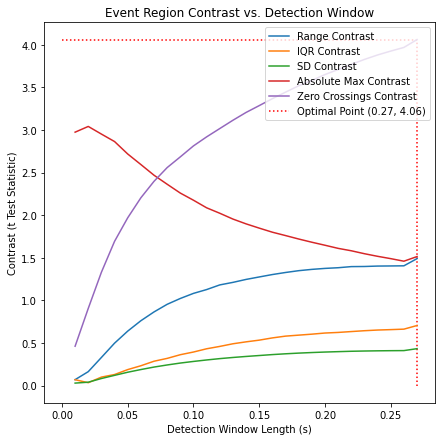

In [28]:
contrasts = pd.read_csv(output_filename_event_det_opt, header=None)
contrasts.columns = ["window_size", "file"] + list(tfn_candidates.keys())
contrasts_total = contrasts.groupby("window_size").mean()

plt.figure(figsize=(7, 7))
for stat in tfn_candidates.keys():
    plt.plot(contrasts_total.index/samprate,
             np.abs(contrasts_total[stat]),
             label = f"{stat} Contrast", alpha = 1)

plt.title("Event Region Contrast vs. Detection Window")
plt.xlabel("Detection Window Length (s)")
plt.ylabel("Contrast (t Test Statistic)")
opt_det_window = contrasts_total.index[np.argmax(np.abs(contrasts_total["Zero Crossings"]))]/samprate
opt_det_window_val = np.max(np.abs(contrasts_total["Zero Crossings"]))
plt.vlines(opt_det_window, 0, opt_det_window_val,"r", ":", 
           label=f"Optimal Point ({round(opt_det_window, 2)}, {round(opt_det_window_val, 2)})")
plt.hlines(opt_det_window_val, 0, opt_det_window,"r", ":")
plt.legend(loc="upper right")
plt.savefig(OUT_PATH+"contrast.png")

```{figure} ../report_outputs/contrast.png
---
scale: 75%
name: contrast
---
Contrast of each test statistic as a function of window size. The contrast is calculated using {eq}`contrast`. We can see that zero crossings produces the maximum contrast at a window length of 0.43 seconds.
```
<!-- reference by {numref}`contrast` -->

##### Threshold Optimisation

Now that we have determined the best test statistic and its corresponding optimal detection window length, we will use these to determine the optimal threshold for event detection. To do this, we perform yet another gridsearch to maximise $F_1$-score. Instead of searching for the threshold, we instead search for a factor with which to multiply the zero crossings of the calibration statistic by to obtain the threshold. This makes the threshold more robust. The results are displayed below in {numref}`threshold`.

In [11]:
output_filename_thresh_opt = OUT_PATH + "threshold_optimisation.csv"

if compute_all:
    open(output_filename_thresh_opt, "w").close() # Clear file
    for st_scale in np.linspace(0.01, 1, 100):
        fps, fns, tps, i = 0, 0, 0, 0
        for key in waves.keys():
            predictions, predictions_timestamps = streaming_classifier(
                waves[key],
                samprate,
                lambda x,y: "R" if np.random.rand()<0.5 else "L",
                input_buffer_size_sec = 0.05,
                classification_window_size_sec = opt_det_window,
                detection_window_size_sec = opt_det_window,
                detection_window_offset_sec = 0,
                calibration_window_size_sec = calibration_window_sec,
                calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                event_threshold_factor = st_scale, 
                flip_threshold = True, 
                consecutive_event_triggers = 3, 
                consecutive_nonevent_reset = 10 
            )
            before_buffer = time_buffers_hump[key][0]
            after_buffer = time_buffers_hump[key][1]
            actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
            actual_leftovers = deepcopy(actual_times)
            pred_leftovers = deepcopy(predictions_timestamps)
            tps += len(actual_times)
            for act_times in actual_times:
                if act_times[1] < calibration_window_sec:
                    actual_leftovers.remove(act_times)
                    continue
                for pred_times in predictions_timestamps:
                    if (act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and
                        pred_times in pred_leftovers and act_times in actual_leftovers):
                        actual_leftovers.remove(act_times)
                        pred_leftovers.remove(pred_times)
            tps -= len(actual_leftovers)
            fns += len(actual_leftovers)
            fps += len(pred_leftovers)
            i += 1
        fscore = tps/(tps+0.5*(fns+fps))
        if (st_scale*100)%10 == 0:
            print(st_scale, fscore)
        with open(output_filename_thresh_opt, "a") as file:
            file.write(f"{st_scale},{fscore}\n")


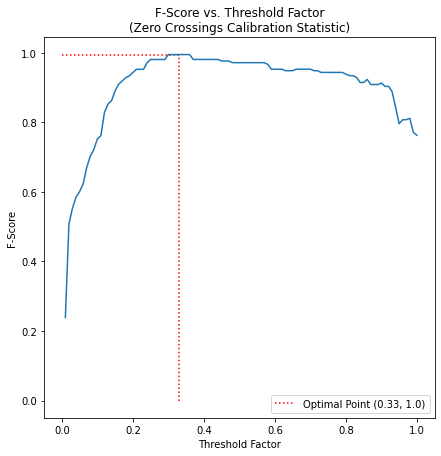

In [12]:
thresholds = pd.read_csv(output_filename_thresh_opt, header=None)
thresholds.columns = ["threshold_factor", "f_score"] 

thresh_factors = thresholds.threshold_factor
f_score_list = thresholds.f_score

plt.figure(figsize=(7, 7))
plt.plot(thresh_factors, f_score_list)
plt.title("F-Score vs. Threshold Factor\n(Zero Crossings Calibration Statistic)")
opt_thresh = np.mean(thresh_factors[f_score_list == np.max(f_score_list)])
opt_fscore = np.max(f_score_list)
plt.vlines(opt_thresh, 0, opt_fscore, "r", ":", 
           label=f"Optimal Point ({round(opt_thresh, 2)}, {round(opt_fscore, 2)})")
plt.hlines(opt_fscore, 0, opt_thresh, "r", ":")
plt.xlabel("Threshold Factor")
plt.ylabel("F-Score")
plt.legend(loc = "lower right")
plt.savefig(OUT_PATH+"threshold.png")

```{figure} ../report_outputs/threshold.png
---
scale: 75%
name: threshold
---
Plot of the $F_1$-score for different threshold factors on the training set. The threshold is obtained by multiplying the zero crossings of the calibration window by the threshold factor. We find the highest $F_1$-score occurs when the threshold factor is 0.33.
```
<!-- reference by {numref}`threshold` -->

#### Classification TO DO

for physics aspect just mention:
- again, what we predict the evaluation graph should look like
- we used a signal to filter the noise for one-three prong (mention its a physics thing to do when explaining classifier)


##### Classifiers

Now that the event detection has been optimised, we must now optimise classification. To do this, the data science team developed five classifiers, each aiming to capture a different distinguishing feature identified by the physics team in their investigations {ref}`methods:exp`. In particular, *One Prong* applies a Savitzky-Golay filter and looks to identify whether the first turning point is a maximum (R) or minimum (L). *Two Prong* does the same, but looks for a max followed by a min (R) or vice versa (L). *Max-Min* essentially does the same as *Two Prong* but without filtering. *Max-Min-Range* applies a correction to *Max-Min* so that it only considers a point to be a maximum or minimum when it is above a certain threshold distance from the origin, governed by the `rng` parameter. The optimisation of this parameter can be found in {ref}`appendix:maxminrange`. Finally, we developed a knn classifier, the optimisation of which can be found in {ref}`appendix:knn`.

In [13]:
# Prepare Classifier Candidates

# catch22 kNN classifier (using stepwise selected features)
step_csv = DEP_PATH+"catch22_step_selected_features.csv"
catch22_step_training_data = pd.read_csv(step_csv)
X_train = catch22_step_training_data.iloc[:,0:-1]
y_labels = catch22_step_training_data.iloc[:,-1]   
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_labels)


# calculates the 5 features selected from catch22, find the 5 nearest neighbours 
# calculated using Euclidean distance, then selects the majority classification
def catch22_knn_classifier(arr, samprate, downsample_rate=10):
    arr_ds = arr[0::downsample_rate]
    arr_list = arr_ds.tolist()
    feature_one = catch22.DN_HistogramMode_5(arr_list)
    feature_two = catch22.SB_BinaryStats_mean_longstretch1(arr_list)
    feature_three = catch22.FC_LocalSimple_mean1_tauresrat(arr_list)
    feature_four = catch22.DN_OutlierInclude_p_001_mdrmd(arr_list)
    feature_five = catch22.SP_Summaries_welch_rect_area_5_1(arr_list)
    test_features = [[feature_one, feature_two, feature_three, feature_four, feature_five]]
    return neigh.predict(test_features)[0]                    

# wave is smoothed using Savitzky-Golay Filter, then decides whether the event is
# a left or right depending on whether the first turning point is a max or min
def one_pronged_smoothing_classifier(arr, samprate, downsample_rate=10, window_size_seconds=0.3, max_loops=10):
    arr_ds = arr[0::downsample_rate]
    fs = samprate/downsample_rate
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)

    # Indices of positive maxima
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    max_vals = filtered_arr[max_locs]
    max_locs = max_locs[max_vals > 0]
    
    # Indices of negative minima
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    min_vals = filtered_arr[min_locs]
    min_locs = min_locs[min_vals < 0]
    
    max_min_locs = np.append(max_locs, min_locs)    # Appended indices
    max_min_values = filtered_arr[max_min_locs]     # Values of above indices    
    abs_max_min_values = np.abs(max_min_values)     # Absolute value of those values

    # A vector with a length equal to the number of minimums: all '-1' to say minimum
    numMin = [-1]*len(min_locs)    
    numMax = [1]*len(max_locs)     # Same for max, but with '1'
    isMin = np.append(numMax, numMin)
    val_and_idx = np.vstack([abs_max_min_values, max_min_locs, isMin])
    # Sort the magnitudes of the extrema in descending order (-1 indicates descending)
    val_and_idx_sorted = val_and_idx[ :, (-1*val_and_idx[0]).argsort()]

    if val_and_idx_sorted.shape == (3, 0):
        if val_and_idx_sorted[2] == -1:
            return 'L'
        elif val_and_idx_sorted[2] == 1:
            return 'R'
        else:
            return "_"
    else:
        if val_and_idx_sorted[2, 0] == -1:
            return 'L'
        elif val_and_idx_sorted[2, 0] == 1:
            return 'R'
        else:
            return "_"

# wave is smoothed using Savitzky-Golay Filter, then decides whether the event is
# a left or right depending on the order of the maximum and minimum turning points
def two_pronged_smoothing_classifier(arr, samprate, downsample_rate=10, 
                                       window_size_seconds=0.3, max_loops=10):
    arr_ds = arr[0::downsample_rate]
    fs = samprate/downsample_rate
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)

    # Indices of positive maxima
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    max_vals = filtered_arr[max_locs]
    max_locs = max_locs[max_vals > 0]
    
    # Indices of negative minima
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    min_vals = filtered_arr[min_locs]
    min_locs = min_locs[min_vals < 0]
    
    max_min_locs = np.append(max_locs, min_locs)    # Appended indices
    max_min_values = filtered_arr[max_min_locs]     # Values of above indices    
    abs_max_min_values = np.abs(max_min_values)     # Absolute value of those values

    # A vector with a length equal to the number of minimums: all '-1' to say minimum
    numMin = [-1]*len(min_locs)    
    numMax = [1]*len(max_locs)     # Same for max, but with '1'
    isMin = np.append(numMax, numMin)
    val_and_idx = np.vstack([abs_max_min_values, max_min_locs, isMin])
    # Sort the magnitudes of the extrema in descending order (-1 indicates descending)
    val_and_idx_sorted = val_and_idx[ :, (-1*val_and_idx[0]).argsort()]
    
    # We will continue looping until we have an appropriate classification. 
    # This relies on having the extrema INTERCHANGE between max and min (no two min right next to eachother)
    loops = 0
    classificationFound = False
    while not classificationFound and loops < max_loops:
        
        top_2 = val_and_idx_sorted[:, 0:2]             # Take the top two magnitudes
        top_2_sorted = top_2[ :, top_2[1].argsort()]   # Sort according to the indices of those values
        if top_2_sorted.shape != (3, 2):               # Break if we run out of turning points
            return "_"
        
        # If two min or two max occur one after the other, 
        # we know we have an inappropriate result so we delete one of those doubled min/max
        if top_2_sorted[2, 0]*top_2_sorted[2, 1] > 0:
            val_and_idx_sorted = np.delete(val_and_idx_sorted, 1, 1)
        else:
            classificationFound = True
        loops += 1
    if top_2_sorted[2, 0] == -1:
        return 'L'
    elif top_2_sorted[2, 0] == 1:
        return 'R'
    else:
        return "_"

# finds the index of the max and min values in the wave, then classifies
# based on whether the max or min value occurred first
def max_min_classifier(arr, samprate, downsample_rate=10):
    arr_ds = arr[0::downsample_rate]
    arr_max = np.amax(arr_ds)
    arr_min = np.amin(arr_ds)
    max_loc = np.where(arr_ds == arr_max)[0][0]
    min_loc = np.where(arr_ds == arr_min)[0][0]
    if max_loc > min_loc:
        return "R"
    elif min_loc > max_loc:
        return "L"
    else:
        return "_"

# finds the index of the max and min values in the wave, then checks whether both
# values are outside the range. If both are outside, then classification is based
# on whether max or min value occurred first. Else, if only one is outside, then
# classification is based on whether the max or min's magnitude is larger
@njit
def max_min_range_classifier(arr, samprate, downsample_rate=10, rng = 35):
    arr_ds = arr[0::downsample_rate]
    arr_max = np.amax(arr_ds)
    arr_min = np.amin(arr_ds)
    max_loc = np.where(arr_ds == arr_max)[0][0]
    min_loc = np.where(arr_ds == arr_min)[0][0]

    if arr_max > rng and arr_min < -1 * rng:
        if max_loc > min_loc:
            return "R"
        elif min_loc > max_loc:
            return "L"
        else:
            return "_"
    elif arr_max > rng:
        return "R"
    elif arr_min < -1 * rng:
        return "L"
    else:
        return "_"


In [14]:
# Prepare classifiers for optimisation and plotting
classifiers = {"One-pronged": one_pronged_smoothing_classifier,
               "Two-pronged": two_pronged_smoothing_classifier,
               "Max-Min": max_min_classifier,
               "Max-Min-Range": max_min_range_classifier,
               "KNN": catch22_knn_classifier,
               "Naive Random": lambda x,y: "R" if np.random.rand()<0.5 else "L"}

classifier_parameters = {"One-pronged": {},
               "Two-pronged": {},
               "Max-Min": {},
               "Max-Min-Range": {"rng":35},
               "KNN": {},
               "Naive Random": {}}

classifier_colours = {"One-pronged": "tab:blue",
               "Two-pronged": "tab:cyan",
               "Max-Min": "tab:olive",
               "Max-Min-Range": "tab:brown",
               "KNN": "tab:pink",
               "Naive Random": "tab:red"}


##### Accuracy Metric

To estimate the accuracy of our classifier, we have opted to use weighted Levenshtein distance. The Levenshtein distance measures the minimum number of deletions, insertions or replacements required to transform one sequence into the other. Our metric weighs replacements and deletions more heavily than insertions, counting a replacement and a deletion as 1.25 and insertions as 0.5. When playing the game, a misclassification (fixed by replacement) would be quite costly, as the game would be doing the opposite of the instruction given. A false positive event (fixed by a deletion) where it detects an event when no instruction was given would also be costly. In contrast, a missed event (fixed by an insertion) is far less costly as the player can simply redo the eye movement. This justifies using the weighted Levenshtein distance to calculate accuracy. Once the weighted Levenshtein distance is calculated, the accuracy is computed using {eq}`lev`: 

```{math}
:label: lev
a = \frac{l-D_{lv}}{l}
```
<!-- reference it by {eq}`lev` -->

where $a$ is the accuracy, $l$ is the length of the actual sequence and $D_{lv}$ is the weighted Levenshtein distance.


In [15]:
def my_lev_dist(prediction, actual, sub_L_cost = 1.25, sub_R_cost = 1.25,
                sub_under_score_cost = 0.5, delete_under_score_cost = 0,
                delete_L_cost = 1.25, delete_R_cost = 1.25):
    substitute_costs = np.ones((128, 128), dtype=np.float64)  
    substitute_costs[ord('L'), ord('R')] = sub_L_cost
    substitute_costs[ord('R'), ord('L')] = sub_R_cost
    substitute_costs[ord('_'), ord('L')] = sub_under_score_cost
    substitute_costs[ord('_'), ord('R')] = sub_under_score_cost
    delete_costs = np.ones(128, dtype=np.float64)
    delete_costs[ord('_')] = delete_under_score_cost
    delete_costs[ord('L')] = delete_L_cost
    delete_costs[ord('R')] = delete_R_cost
    return lev(prediction, actual, substitute_costs = substitute_costs, delete_costs = delete_costs)


##### Latency Analysis

The actual time taken for each algorithm to classify is negligible (analysis of which can be found in the Appendix at {ref}`appendix:latency`). This means the classification lag is dominated by the length of the classification window, as the stream has to wait for the window to come in before it can classify. Hence, the accuracy defined in {eq}`lev` must be balanced with a minimum classification window length to optimise the classifier's performance.


##### Classifier Optimisation

Once the metric has been defined, a series of grid searches were performed for classifier to optimise the classification window size. Using the detection window as a base, an extension was applied on either side of the detection window to slowly widen the classification window. This extension was varied from 0 seconds to 1.65 seconds in increments of 0.00825 seconds and the accuracy at each step was plotted below in {numref}`classifier`.

In [16]:
output_filename_cls_opt = OUT_PATH + "classifier_optimisation.csv"

if compute_all:
    open(output_filename_cls_opt, 'w').close()    # Clear the file

    search_space = (2-opt_det_window)/2
    granularity = 200

    for classifier_label, classifier in classifiers.items():
        print(classifier_label)
        for i, w in enumerate(np.linspace(0, search_space, granularity)):
            w = max(1e-5, w)
            if i%(granularity//10) == 0:
                print(f"{i} of {granularity}")
            classification_window = opt_det_window+2*w
            buffer_size = 0.05
            for i, key in enumerate(waves):
                predictions, predictions_timestamps = streaming_classifier(
                    waves[key],
                    samprate,
                    classifier,
                    classifier_params=classifier_parameters[classifier_label],
                    input_buffer_size_sec = buffer_size,
                    classification_window_size_sec = classification_window,
                    detection_window_size_sec = opt_det_window,
                    detection_window_offset_sec = w,
                    calibration_window_size_sec = calibration_window_sec,
                    calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                    event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                    event_threshold_factor = opt_thresh, 
                    flip_threshold = True, # Threshold is a lower bound, so true
                    consecutive_event_triggers = 3, 
                    consecutive_nonevent_reset = 10 
                )
                actuals = "".join(labels[key].label)
                lev_dist = my_lev_dist(predictions, actuals)
                acc = max((len(actuals) - lev_dist), 0)/len(actuals)
                with open(output_filename_cls_opt, "a") as file:
                    file.write(",".join([classifier_label, str(classification_window), 
                                         key, predictions, actuals, str(lev_dist), str(acc)]) + '\n')
                    
results = pd.read_csv(output_filename_cls_opt, header=None)
results.columns = ["classifier", "window_size", "file", "predicted", "actual", "lev_dist", "accuracy"]
results_agg = results.groupby(["window_size", "classifier"]).mean()
results_agg.reset_index(inplace=True)


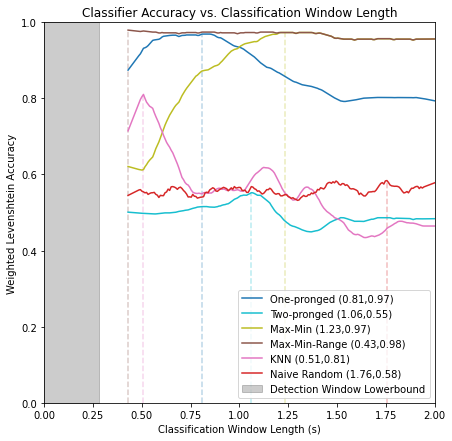

In [17]:
optimal_cl_windows = {}

plt.figure(figsize=(7, 7))
for classifier in results.classifier.unique():
    filt = results_agg.classifier == classifier
    max_arg = np.argmax(signal.savgol_filter(results_agg[filt].accuracy, 15, 1))
    max_val = np.max(signal.savgol_filter(results_agg[filt].accuracy, 15, 1))
    optimal_cl_window = np.array(results_agg[filt].window_size)[max_arg]
    optimal_cl_windows[classifier] = optimal_cl_window
    
    plt.plot(results_agg[filt].window_size, signal.savgol_filter(results_agg[filt].accuracy, 15, 1),
             label=classifier + f" ({round(optimal_cl_window, 2)},{min(round(max_val, 2), 1.0)})", 
             color=classifier_colours[classifier])
    plt.vlines(optimal_cl_window, 0, max_val, color=classifier_colours[classifier], linestyle="--", alpha=0.3)
    
plt.ylabel("Weighted Levenshtein Accuracy")
plt.xlabel("Classification Window Length (s)")
plt.title("Classifier Accuracy vs. Classification Window Length")
plt.ylim(0, 1)
plt.xlim(0, 2)

plt.fill_between([0, opt_det_window], 0, 1, color="k", alpha = 0.2, label="Detection Window Lowerbound")


plt.legend(loc="lower right")
plt.savefig(OUT_PATH+"classifier.png")

```{figure} ../report_outputs/classifier.png
---
scale: 75%
name: classifier
---
Training accuracy of each classifier as a function of classification window length. The classification window is lower bounded by the detection window, represented by the shaded region.
Ideally, we want to minimise window length while maximising accuracy. With this in mind, we see that the Max-Min-Range classifier has the highest accuracy at a window length equal to be the lowerbound of 0.43 seconds. This makes it the most optimal classifier by both accuracy and latency.
```
<!-- reference by {numref}`classifier` -->

#### Evaluation

In [18]:
output_filename_tst_res = OUT_PATH + "test_results.csv"

if compute_all:
    open(output_filename_tst_res, 'w').close()    # Clear the file

    for classifier_label, classifier in classifiers.items():
        print(classifier_label)
        offset = (optimal_cl_windows[classifier_label] - opt_det_window)/2
        buffer_size = 0.05
        for i, key in enumerate(test_waves):
            predictions, predictions_timestamps = streaming_classifier(
                test_waves[key],
                samprate,
                classifier,
                classifier_params=classifier_parameters[classifier_label],
                input_buffer_size_sec = buffer_size,
                classification_window_size_sec = optimal_cl_windows[classifier_label],
                detection_window_size_sec = opt_det_window,
                detection_window_offset_sec = offset,
                calibration_window_size_sec = calibration_window_sec,
                calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                event_threshold_factor = opt_thresh, 
                flip_threshold = True,
                consecutive_event_triggers = 3, 
                consecutive_nonevent_reset = 10 
            )
            actuals = "".join(test_labels[key].label)
            lev_dist = my_lev_dist(predictions, actuals)
            acc = max((len(actuals) - lev_dist), 0)/len(actuals)
            with open(output_filename_tst_res, "a") as file:
                file.write(",".join([classifier_label, key, predictions, actuals, str(lev_dist), str(acc)]) + '\n')

test_results = pd.read_csv(output_filename_tst_res, header=None)
test_results.columns = ["Classifier", "File", "Predicted", "Actual", "Weighted Levenshtein Distance", "Accuracy"]

test_results = test_results.pivot(index = "File", columns='Classifier', values='Accuracy')

top_accs = test_results.mean().sort_values(ascending=False)
top = test_results.mean().sort_values(ascending=False).index
top_windows = [optimal_cl_windows[k] for k in test_results.mean().sort_values(ascending=False).index]

top_df = pd.DataFrame()

top_df["Classifier"] = top
top_df["Accuracy"] = np.round(np.array(top_accs), 2)
top_df["Window Length (s)"] = np.round(np.array(top_windows), 2)


## Summary of results

### Physics - Analysis of Findings: 
After experimenting with different methods of data collection, we concluded that the most optimal placement of the electrodes is when they are at least 3cm apart. We saw that when the eye movements were slow, the signal would become two separate waves, rather than the desired single wave. So, we performed relatively quick eye movements to generate the appropriate signals that our classifier can detect. 
After deliberation, we decided on using left and right eye movements, with the electrodes placed horizontally above the eyes, as the controls for our game. 



### Data Analysis

As per the graphs in the ‘Methods’ section, the best detection window size was 0.43 seconds and the best smart threshold was 0.33.
After considering the tradeoff between latenct and accuracy of each classifier, we decided to use the Zero-Crossings classifier with a classification window size of 0.43 seconds. We chose to use the detection window size as the classification window size as it kept the latency low, without compromising on the event detection performance. Even an increase in window size of 0.1 seconds would greatly reduce the quality of the game due to the increased latency that it causes. Regardless, reducing the window size still maintained the accuracy of the classifier.


### Deployment Process

Our version of Space Invaders was adapted into Python from a team member’s existing Java implementation. The optimised classifier was then merged with the game. However, despite both working well independently, the combined product had massive latency when ran. This was resolved by running the classifier and game separately and having them interact via inter-process communication.

## Discussion 

Initially, the Spike Recorder software was used to record the data required to train and evaluate our data pipeline’s performance. However, the data was drastically different when transitioning to live data from Python. Both the threshold and shape of the signals varied between the two. This led to us re-evaluating all of the parameters of the data pipeline and performing normalisation on the new data. 

The data obtained from the Python software had a tendency to be volatile as the random noise varied greatly with different people. This was solved by the physicists by introducing a calibration period; having the player keep their eyes still for 5 seconds. This allowed us to adjust our parameters accordingly to the individual based on the amount of noise within the calibration period. Additionally, a few classifiers filter out the random noise in the data and make the waves smooth. The main cause of the random noise was, in our experience, some SpikerBoxes not working properly. So, we could reliably eliminate the volatility of the random noise by using a well-tuned SpikerBox.

Latency was a major problem in the initial stages of this project. There was a significant time delay between the eye movement and the `streaming_classifier` function being able to classify the eye movement. This was overcome by significantly reducing the window size. Additionally, when running the `streaming_classifier` function and the game in one file, we encountered significant lag. We resolved this by separating the function and the game into different files and running them at the same time. They interface through the use of inter-process communication.

Due to limited time, we focused on making the core mechanics of left and right eye movement optimised. However, prior to deployment, additional features can be added to the game. An appropriate extra control would be blinking or muscle movements to implement controlled shooting. Additionally, a multiplayer version will attract further attention as it would allow for interation between players. Removing the use of named pipes and making the game self-contained would also improve its efficiency. 

## Conclusion

Physics and data science disciplines collaborated to develop a modern twist on the classic arcade game Space Invaders, where players now control the game with their eyes. By developing and evaluating numerous classifiers using curated data from the physicists, we were able to create a functioning game that utilises left and right eye movements. Due to the time restrictions, we were limited in the amount of controls we were able to implement. However, we aspire to develop future upgrades to the game. These include having user-inputted shooting executed by another control such as blinks or muscle movements and creating a multiplayer option. Despite the challenging nature of this project, we were able to combine data science and physics expertise to develop a very successful final product.

## Contributions

Student 490423356 was responsible for editing the given python streaming code to save the input as a wav file, and automate logging the time keys were pressed during data collection (key presses were used to signal the event an eye movement). They aided in the construction and implementation of physical experiments to determine the most appropriate final experimental design.They implemented an event detection method which uses Fourier transforms, that was evaluated by the group in the test statistic graphical analysis. They performed research on six different types of normalisation techniques that could be used for preprocessing an input signal. Some of these were transformed into event detection statistics, such as Z-Score. They additionally proposed the idea to have a calibration period, which the group agreed is a better method to generalise the signal for all users rather than normalisation. They designed and implemented an adaptation of the existing two and three prong classifiers, to make them more robust to unexpected changes in the signal. This student wrote the speech for the final presentation. They were also responsible for organising meeting times and having the PowerPoint ready for each Monday presentation (with help from other group members).

Student 490413128: Wrote the Max-Min classifier and the Max-Min-Range classifier. Significantly contributed to writing the code for the evaluation. Researched and implemented Inter-Process Communication. Collected a lot of data. Contributed significantly to writing the discussion section. Helped in writing the methods section. Wrote the results section of the report. Rewrote the executive summary so that the report fell within the word limit. Helped in creating the Powerpoint for each Monday presentation.

480366780 contributed to this project through generating reliable and robust data that was used to evaluate the accuracy of the classifiers. They worked on finding distinct signals that we were able to be incorporated as the controls of the game. They evaluated the optimal positioning of the electrodes and distance the eye must move to generate the clearest and most noticeable signals. They created a survey that allowed us to gain a better understanding of the public’s interest towards our project which also helped shape our motivation. They helped with implementing Fourier transforms as an alternative option for event detection and aided in the research of using pipes. They created the slides for the final presentation, helped write the speech and wrote parts of the final report. They also helped research Inter-Process Communication. 

Student 490155963 contributed to this project by converting the Space Invaders he had from Java into Python. He also helped with recording some of the data. He was the primary team member working on merging the classifier and game together, and reducing the lag the combined product was producing. He implemented the classifier on the game with the help of a pipe data processing structure.

Student 490388088 contributed to this project by exploring a machine-learning alternative to the rule-based classifiers the other data science members made. He explored how to use catch22, performed feature selection, and created a k-nearest neighbours classifier to complement the other classifiers. He also contributed significantly to the writing of the reproducible report.

Student 480380144: I developed the structure for our streaming classifier, translating it from R. I also designed the data science pipeline to optimise our classifiers. This involved designing and performing experiments to optimise for each of the parameters in the streaming classifier, specifically detection and classification window lengths. I also played a key role in writing our report, including setting up Jupyter Book and interlacing the sections with the code for reproducibility. Overall, I think my most important contribution was providing direction to our group. By laying out the experimental pipeline, it allowed all group members to contribute to the final product more effectively.





## Appendix

In [19]:
def encode_msg_size(size: int) -> bytes:
    return struct.pack("<I", size)

def decode_msg_size(size_bytes: bytes) -> int:
    return struct.unpack("<I", size_bytes)[0]

def create_msg(content: bytes) -> bytes:
    size = len(content)
    return encode_msg_size(size) + content


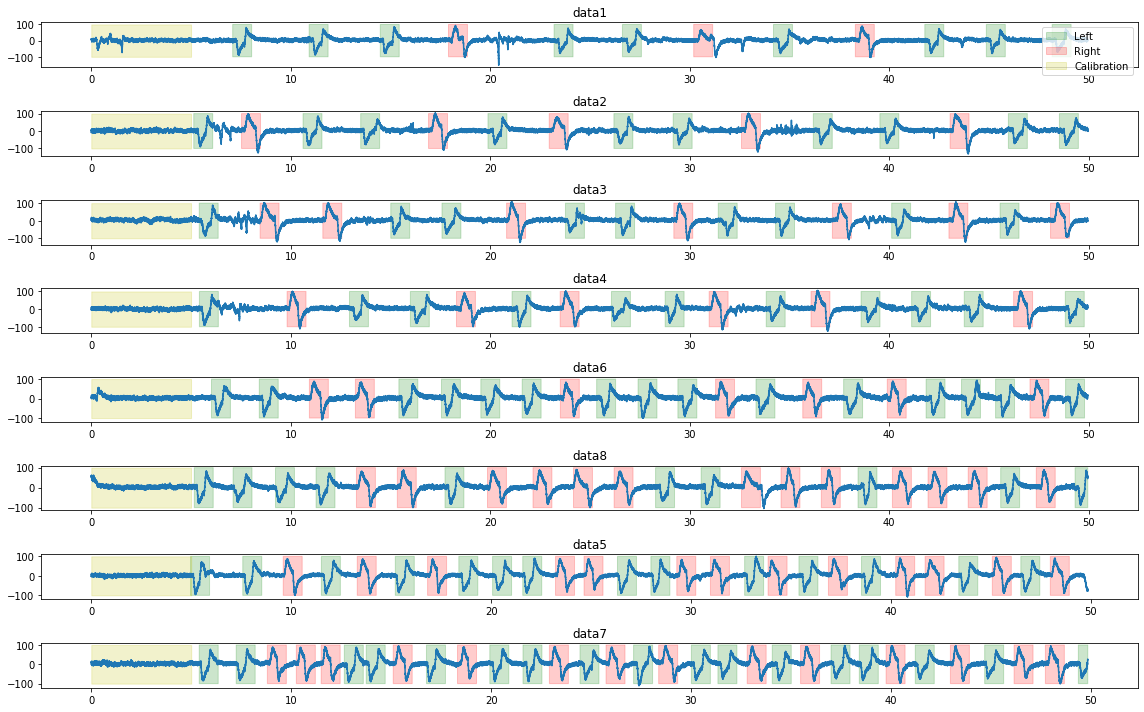

In [20]:
def plot_labelled_wave(wav_array, samprate, labels_dat, ax, i, title="", calibration_seconds = 5, 
                       before_buffer = 1, after_buffer = 1, shade_alpha=0.2, wave_alpha=1, 
                       ymin = -512, ymax = 512):
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate
    
    # Calibration period
    calibration_bool = time_seq < calibration_seconds

    # Get locations of events
    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool
    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool

    # Plot wave with events
    ax[i].plot(time_seq, wav_array, alpha=wave_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = left_events_bool,
                     color = 'g',
                     label = "Left",
                     alpha=shade_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = right_events_bool,
                     color = 'r',
                     label = "Right",
                     alpha=shade_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = calibration_bool,
                     color = 'y',
                     label = "Calibration",
                     alpha=shade_alpha)
    ax[i].set_title(title)
        

fig, ax = plt.subplots(8, 1)
fig.set_size_inches(16, 10)
for i, key in enumerate(sorted(waves.keys())):
    plot_labelled_wave(
        waves[key], samprate, labels[key], ax, i, title=key, before_buffer = time_buffers_whole[key][0],
        after_buffer = time_buffers_whole[key][1], shade_alpha=0.2, wave_alpha=1, ymin = -100, ymax = 100
    )
for i, key in enumerate(sorted(test_waves.keys())):
    plot_labelled_wave(
        test_waves[key], samprate, test_labels[key], ax, i+6, title=key, before_buffer = time_buffers_whole[key][0],
        after_buffer = time_buffers_whole[key][1], shade_alpha=0.2, wave_alpha=1, ymin = -100, ymax = 100
    )
ax[0].legend()
fig.tight_layout()
fig.savefig(OUT_PATH + "dataset_plot.png")


In [21]:
# Final classifier used for Space Invaders

# Connect to spiker box - change to match port
# cport = "/dev/cu.usbserial-DJ00E33Q"
# baudrate = 230400
# ser = serial.Serial(port=cport, baudrate=baudrate)    
# inputBufferSize = 1000   # 20000 = 1 second
# buffer_size_sec = inputBufferSize/20000.0
# ser.timeout = buffer_size_sec  # set read timeout 20000

# classifier_label = "Max-Min-Range"
# offset = (optimal_cl_windows[classifier_label] - opt_det_window)/2
# buffer_size = 0.05
# streaming_classifier(
#     ser,
#     samprate,
#     classifiers[classifier_label],
#     classifier_params=classifier_parameters[classifier_label],
#     input_buffer_size_sec = buffer_size_sec,
#     classification_window_size_sec = optimal_cl_windows[classifier_label],
#     detection_window_size_sec = opt_det_window,
#     detection_window_offset_sec = offset,
#     calibration_window_size_sec = calibration_window_sec,
#     calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
#     event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
#     event_threshold_factor = opt_thresh, 
#     flip_threshold = True, 
#     consecutive_event_triggers = 3, 
#     consecutive_nonevent_reset = 10,
#     live = True,
#     FIFO_filename = "space_invaders_ipc",
#     create_FIFO_msg = None,
#     )


### Test Set Accuracies

In [22]:
top_df

Classifier  Accuracy  Window Length (s)
0        Max-Min      0.90               1.23
1  Max-Min-Range      0.88               0.43
2    One-pronged      0.85               0.81
3            KNN      0.78               0.51
4    Two-pronged      0.70               1.06
5   Naive Random      0.61               1.76

(appendix:consecutive)=
### Triggers and Reset Optimisation

Below is the gridsearch used to optimise `consecutive_event_triggers` and `consecutive_nonevent_reset`. We chose the minimum pair with optimal f score of 0.993 - (3, 10). A minimum pair minimises latency.

In [23]:
# Gridsearch to optimise consecutive_event_triggers and consecutive_nonevent_reset
# Chose minimum pair with optimal f score of 0.993 - (3, 10). A minimum pair minimises latency
if compute_all:
    trigset = {}
    for trigs in range(1, 6):
        for reset in range(5, 25):
            fscores = []
            for key in waves.keys():
                fps, fns, tps, i = 0, 0, 0, 0
                predictions, predictions_timestamps = streaming_classifier(
                    waves[key],
                    samprate,
                    lambda x,y: "R" if np.random.rand()<0.5 else "L",
                    input_buffer_size_sec = 0.05,
                    classification_window_size_sec = opt_det_window,
                    detection_window_size_sec = opt_det_window,
                    detection_window_offset_sec = 0,
                    calibration_window_size_sec = calibration_window_sec,
                    calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                    event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                    event_threshold_factor = 0.33, 
                    flip_threshold = True, 
                    consecutive_event_triggers = trigs, 
                    consecutive_nonevent_reset = reset
                )
                before_buffer = time_buffers_hump[key][0]
                after_buffer = time_buffers_hump[key][1]
                actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
                actual_leftovers = deepcopy(actual_times)
                pred_leftovers = deepcopy(predictions_timestamps)
                tps += len(actual_times)
                for act_times in actual_times:
                    if act_times[1] < calibration_window_sec:
                        actual_leftovers.remove(act_times)
                        continue
                    for pred_times in predictions_timestamps:
                        if (act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and
                            pred_times in pred_leftovers and act_times in actual_leftovers):
                            actual_leftovers.remove(act_times)
                            pred_leftovers.remove(pred_times)
                tps -= len(actual_leftovers)
                fns += len(actual_leftovers)
                fps += len(pred_leftovers)
                i += 1
                fscore = tps/(tps+0.5*(fns+fps))
                fscores.append(fscore)
            print(trigs, reset, np.mean(fscores))
            trigset[(trigs, reset)] = np.mean(fscores)


        
        

(appendix:knn)=
### KNN Optimisation

Below is the code used to perform feature selection on the features calculated using catch22 for the kNN classifier. An external set of data was used to determine these features as to not bias the optimisation process undertaken in {ref}`methods:opt`.
This feature data was saved to `catch22_step_selected_features.csv` for use in the kNN classifier. The method undertaken to perform feature selection is described in {cite}`kaggle`.

In [24]:
# Using backward stepwise feature selection from catch22 for kNN classifier 

# import decision tree classifier to model fitting and recursive feature exclusion (stepwise selection)

KNN_DATA_PATH = IN_PATH + "KNN/"

knn_names = ['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 
            'left-middle-right-steph2', 'left-middle', 'left-right-middle-marina', 'left-right-middle-marina2', 
            'left-right-middle-marina3', 'left-right-middle-sandeep', 'right-middle']

# Load the data
knn_waves, knn_labels = load_data(
    KNN_DATA_PATH, knn_names, scale_factor = 1, shift_factor = -512, fix_alessandro=False)

# Define sample rate: 10,000 Hz
samprate = 10_000

# Extract events from training data
before_buffer = 0.5
after_buffer = 1
    
events = [] # list of events in terms of slice of wav_array
event_labels = [] # list of labels

for key in knn_labels:
    wave = knn_waves[key]
    label = knn_labels[key]
    for lab, time in zip(label.label, label.time):
        event_labels.append(lab)
        event_start = int((time - before_buffer) * samprate) # in terms of sampling rate
        event_end = int((time + after_buffer) * samprate) # in terms of sampling rate

        events.append(wave[event_start:event_end])
        
# Compute catch22 features and convert to dataframe
features = []
for event in events:
    event_ds = event[0::10] # downsample by a rate of 10
    feature = catch22_all(event_ds)
    features.append(feature['values'])

features_df = pd.DataFrame(features)
features_df.columns = feature['names']

# fit the model
clf = DecisionTreeClassifier(random_state=420)
clf.fit(features_df, event_labels)

# Python backward stepwise selection
trans = RFECV(clf, cv=5)
features_trans = trans.fit_transform(features_df, event_labels)

print(features_trans.shape)
columns_retained = features_df.iloc[:, :].columns[trans.get_support()].values
print(columns_retained)

# create df to save as csv for kNN classifier
selected_features_df = pd.DataFrame(features_trans)
selected_features_df.columns = columns_retained
selected_features_df['labels'] = event_labels

# selected_features_df.to_csv(DEP_PATH+'catch22_step_selected_features.csv',index=False)



Successfully loaded 10 wavefiles:
left-middle
left-middle-right-middle
left-middle-right-middle#2
left-middle-right-steph
left-middle-right-steph2
left-right-middle-marina
left-right-middle-marina2
left-right-middle-marina3
left-right-middle-sandeep
right-middle
(215, 5)
['DN_HistogramMode_5' 'SB_BinaryStats_mean_longstretch1'
 'FC_LocalSimple_mean1_tauresrat' 'DN_OutlierInclude_p_001_mdrmd'
 'SP_Summaries_welch_rect_area_5_1']


(appendix:maxminrange)=
### Max-Min-Range Optimisation
The following code performs a grid search to optimise the `rng` threshold for the Max-Min-Range classifier. The `rng` threshold is varied from 0 to 100 in increments of 1, and the corresponding weighted Levenshtein accuracies are plotted.

In [25]:
# Gridsearch to optimise consecutive_event_triggers and consecutive_nonevent_reset
# Chose minimum pair with optimal f score of 0.993 - (3, 10). A minimum pair minimises latency
if compute_all:
    trigset = {}
    for trigs in range(1, 6):
        for reset in range(5, 25):
            fscores = []
            for key in waves.keys():
                fps, fns, tps, i = 0, 0, 0, 0
                predictions, predictions_timestamps = streaming_classifier(
                    waves[key],
                    samprate,
                    lambda x,y: "R" if np.random.rand()<0.5 else "L",
                    input_buffer_size_sec = 0.05,
                    classification_window_size_sec = opt_det_window,
                    detection_window_size_sec = opt_det_window,
                    detection_window_offset_sec = 0,
                    calibration_window_size_sec = calibration_window_sec,
                    calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                    event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                    event_threshold_factor = 0.33, 
                    flip_threshold = True, 
                    consecutive_event_triggers = trigs, 
                    consecutive_nonevent_reset = reset
                )
                before_buffer = time_buffers_hump[key][0]
                after_buffer = time_buffers_hump[key][1]
                actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
                actual_leftovers = deepcopy(actual_times)
                pred_leftovers = deepcopy(predictions_timestamps)
                tps += len(actual_times)
                for act_times in actual_times:
                    if act_times[1] < calibration_window_sec:
                        actual_leftovers.remove(act_times)
                        continue
                    for pred_times in predictions_timestamps:
                        if (act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and
                            pred_times in pred_leftovers and act_times in actual_leftovers):
                            actual_leftovers.remove(act_times)
                            pred_leftovers.remove(pred_times)
                tps -= len(actual_leftovers)
                fns += len(actual_leftovers)
                fps += len(pred_leftovers)
                i += 1
                fscore = tps/(tps+0.5*(fns+fps))
                fscores.append(fscore)
            print(trigs, reset, np.mean(fscores))
            trigset[(trigs, reset)] = np.mean(fscores)


        
        

The following code performs a grid search to optimise the `rng` threshold for the Max-Min-Range classifier. The `rng` threshold is varied from 0 to 100 in increments of 1, and the corresponding weighted Levenshtein accuracies are plotted.

In [26]:
classifiers1 = {"Max-Min-Range": max_min_range_classifier}

file_accuracies = {}

buffer_size_sec = 0.05

if compute_all:
    for classifier_label, classifier in classifiers1.items():
        #offset = (optimal_cl_windows[classifier_label] - opt_det_window)/2
        print(classifier_label)
        for range_threshold in np.linspace(0, 100, 101):
            print("\nCurrent Range Threshold:", range_threshold)

            current_accuracies = []
            for i, key in enumerate(waves):
                
                predictions, predictions_timestamps = streaming_classifier(
                    waves[key],
                    samprate,
                    classifiers[classifier_label],
                    classifier_params={"rng" : range_threshold},
                    input_buffer_size_sec = buffer_size_sec,
                    classification_window_size_sec = opt_det_window,  #opt_det_window + 0.01
                    detection_window_size_sec = opt_det_window,       #opt_det_window
                    detection_window_offset_sec = 0,   #offset ^ uncomment it above
                    calibration_window_size_sec = 5,
                    calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                    event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                    event_threshold_factor = 0.33,          #opt_thresh 
                    flip_threshold = True, 
                    consecutive_event_triggers = 3, 
                    consecutive_nonevent_reset = 10,
                    live = False,
                )
                actuals = "".join(labels[key].label)

                lev_dist = my_lev_dist(actuals, predictions)
                acc = abs(len(actuals) - lev_dist)/len(actuals)
                current_accuracies.append(acc)
            if range_threshold in file_accuracies:
                file_accuracies[range_threshold] += current_accuracies
            else:
                file_accuracies[range_threshold] = current_accuracies


    ave_accuracies_per_range_val = {}
    for range_thresh, acc_each_file_ls in file_accuracies.items():
        ave_accuracies_per_range_val[range_thresh] = sum(acc_each_file_ls) / len(acc_each_file_ls)
    print("done")

    best_ranges = []
    best_value = 0
    for acc in ave_accuracies_per_range_val.values():
        if round(acc, 5) > round(best_value, 5):  #need to round because python maintains its floats very imprecisly
            best_value = acc

    for key, value in ave_accuracies_per_range_val.items():
        if round(value, 5) == round(best_value, 5):
            best_ranges.append(key)

    plt.figure(figsize=(10, 10))
    plt.plot(ave_accuracies_per_range_val.keys(), ave_accuracies_per_range_val.values())
    if len(best_ranges) > 1:
        plt.vlines(best_ranges[0], 0, best_value, linestyle=":", label=f"Best Ranges: {round(best_ranges[0], 2)} to {round(best_ranges[len(best_ranges) - 1], 2)}, Accuracy = {round        (best_value, 2)}")
        plt.vlines(best_ranges[len(best_ranges) - 1], 0, best_value, linestyle=":")
        plt.axvspan(best_ranges[0], best_ranges[len(best_ranges) - 1], alpha=0.1, color='red')
    else:
        plt.vlines(best_ranges[0], 0, best_value, linestyle=":", label=f"Best Range: {round(best_ranges[0], 2)}, Accuracy = {round(best_value, 2)}")

    plt.legend(loc = "lower right")
    plt.ylabel("Weighted Levenshtein Accuracy")
    plt.xlabel("Range Threshold")
    plt.title("Classifier Accuracy vs. Range Threshold for Window Size of 0.46 Seconds")

## References 

The following python packages were used in this report: Numpy {cite}`numpy`, Pandas {cite}`pandas`, Scipy {cite}`scipy`, matplotlib {cite}`plot`, catch22 {cite}`catch22`, sci-kit learn {cite}`sklearn`, numba {cite}`numba`, levdist {cite}`levdist`, and pyserial {cite}`serial`


```{bibliography}
:all:
```